In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.models import Sequential

In [12]:
# https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download
data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", header=None)
data = data[[0,5]]
data.columns = ["sentiment", "text"]

data["sentiment"] = data["sentiment"].replace(4, 1)

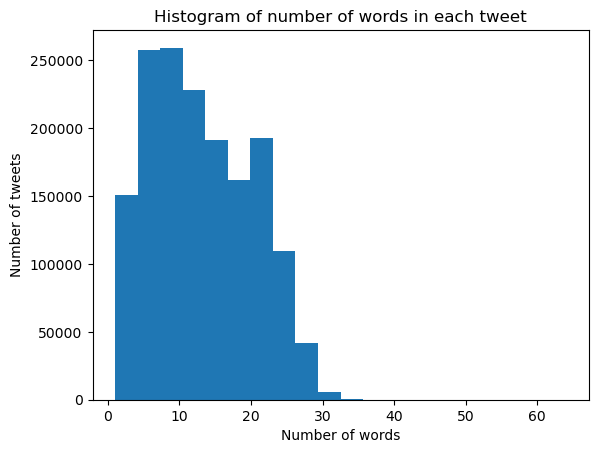

In [13]:
# Calculating number of words in each tweet:
data["word_count"] = data["text"].apply(lambda x: len(x.split()))
# plot histogram of number of words:
plt.hist(data["word_count"], bins=20)
plt.title("Histogram of number of words in each tweet")
plt.xlabel("Number of words")
plt.ylabel("Number of tweets")
data.drop("word_count", axis=1, inplace=True)

Due to twitter forcably limiting the number of characters, the number of words in each tweet are fairly constrained to under 30 words per tweet. For this reason we find it appropriate to use 30 word fixed length sequcnes for our models.

In [14]:
data.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

## Metrics
#### Accuracy:

Because the dataset is balanced, accuracy is an appropriate metric to use on our dataset. Our models will potentially be used to measure sentiment regarding certain topics on twitter and accuracy is a good measure to gauge the classification performance for that task.


## Splitting:

We will use a standard 80-20 train test split. We have enough data, 1.6M tweets split evently amoung two classes is enough data to train and evaluate with.

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data["text"], data["sentiment"], test_size=0.2, random_state=42)

## Creating Embedding Layer:

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % (len(word_index)))

Found 594848 unique tokens.


In [17]:
%%time
EMBED_SIZE = 200
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.twitter.27B.200d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 1193514 word vectors.
Embedding Shape: (594849, 200) 
 Total words found: 121078 
 Percentage: 20.35440927025178
CPU times: user 38.5 s, sys: 1.58 s, total: 40.1 s
Wall time: 40.2 s


In [18]:
X_train = pad_sequences(X_train_sequences, maxlen=30)
X_test = pad_sequences(X_test_sequences, maxlen=30)

In [19]:

MAX_ART_LEN = 30

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

## Modeling:

In [20]:
def plot_history(history):
    # plot history of the model:
    fig = plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validate')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over epochs')

In [21]:
rnn1 = Sequential()
rnn1.add(embedding_layer)
rnn1.add(LSTM(100))
rnn1.add(Dense(1, activation='sigmoid'))
rnn1.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn1.summary()

2022-12-12 22:29:11.588309: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 22:29:12.255428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30971 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 119,090,301
Trainable params: 120,501
Non-trainable params: 118,969,800
_________________________________________________________________


In [22]:
history_rnn_1 = rnn1.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=2048)

Epoch 1/20


2022-12-12 22:29:15.076763: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-12 22:29:16.158601: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x2ab4e21a07a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-12-12 22:29:16.158638: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-12-12 22:29:16.164002: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-12 22:29:16.537549: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 [==============================] - 10s 10ms/step - loss: 0.4561 - accuracy: 0.7827 - val_loss: 0.4220 - val_accuracy: 0.8038
Epoch 2/20
625/625 [==============================] - 6s 9ms/step - loss: 0.4120 - accuracy: 0.8104 - val_loss: 0.4040 - val_accuracy: 0.8140
Epoch 3/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3966 - accuracy: 0.8189 - val_loss: 0.3980 - val_accuracy: 0.8174
Epoch 4/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3866 - accuracy: 0.8245 - val_loss: 0.3892 - val_accuracy: 0.8228
Epoch 5/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3791 - accuracy: 0.8286 - val_loss: 0.3850 - val_accuracy: 0.8251
Epoch 6/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3729 - accuracy: 0.8322 - val_loss: 0.3833 - val_accuracy: 0.8259
Epoch 7/20
625/625 [==============================] - 6s 9ms/step - loss: 0.3677 - accuracy: 0.8352 - val_loss: 0.3817 - val_accuracy: 0.8272
Epoch 8/20
625/

KeyboardInterrupt: 

In [ ]:
plot_history(history_rnn_1)

In [ ]:
rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(LSTM(100, dropout=0.2))
rnn2.add(Dense(1, activation='sigmoid'))
rnn2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
rnn2.summary()

In [ ]:
history_rnn_2 = rnn2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=2048)

In [ ]:
plot_history(history_rnn_2)

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 200 #embedding size
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 30

embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)
x = Dropout(0.15)(x)
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(x)


x = Dropout(0.2)(x)
x = Conv1D(256, 3, activation='relu',
           kernel_initializer='he_uniform')(x)

x = MaxPooling1D(24)(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
opt = keras.optimizers.Nadam()
cnn1 = Model(sequence_input, preds)
cnn1.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

print(cnn1.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 conv1d_18 (Conv1D)          (None, 28, 256)           153856    
                                                                 
 dropout_18 (Dropout)        (None, 28, 256)           0         
                                                                 
 conv1d_19 (Conv1D)          (None, 26, 256)           196864    
                                                                 
 dropout_19 (Dropout)        (None, 26, 256)           0         
                                                                 
 conv1d_20 (Conv1D)          (None, 24, 256)           1968

In [40]:
cnn_hist = model.fit(X_train, y_train, validation_data=(X_test, y_test),
epochs=10, batch_size=2048)

Epoch 1/10
625/625 [==============================] - 20s 29ms/step - loss: 0.4760 - acc: 0.7700 - val_loss: 0.4299 - val_acc: 0.8024
Epoch 2/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4183 - acc: 0.8070 - val_loss: 0.4062 - val_acc: 0.8153
Epoch 3/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4018 - acc: 0.8167 - val_loss: 0.3974 - val_acc: 0.8209
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3914 - acc: 0.8224 - val_loss: 0.3917 - val_acc: 0.8234
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3833 - acc: 0.8266 - val_loss: 0.3877 - val_acc: 0.8247
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3768 - acc: 0.8300 - val_loss: 0.3857 - val_acc: 0.8260
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3717 - acc: 0.8329 - val_loss: 0.3839 - val_acc: 0.8268
Epoch 8/10
625/625 [==============================] - 18s 29ms

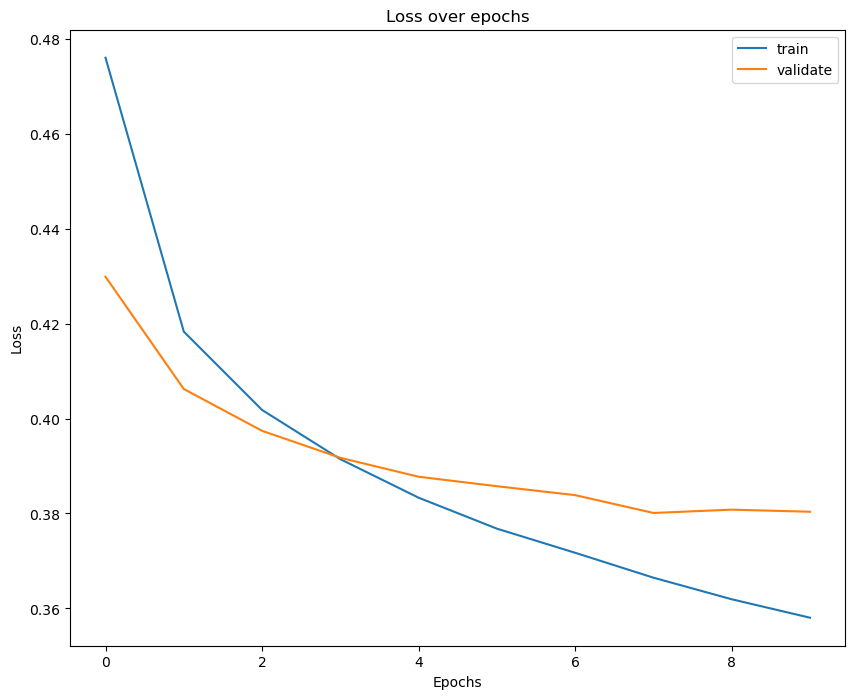

In [41]:
plot_history(cnn_hist)

In [36]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.layers import Embedding

EMBED_SIZE = 200 #embedding size
sequence_input = Input(shape=(MAX_ART_LEN,), dtype='int32')
# starting size: 30

embedded_sequences = embedding_layer(sequence_input) # from previous embedding
x = Conv1D(256, 7, activation='relu',
           kernel_initializer='he_uniform')(embedded_sequences)
x = Dropout(0.15)(x)
x = Conv1D(256, 7, activation='relu',
           kernel_initializer='he_uniform')(x)


x = Dropout(0.2)(x)
x = Conv1D(256, 7, activation='relu',
           kernel_initializer='he_uniform')(x)

x = MaxPooling1D(12)(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu',
          kernel_initializer='he_uniform')(x)

preds = Dense(1, activation='sigmoid',
              kernel_initializer='glorot_uniform')(x)
opt = keras.optimizers.Nadam()
cnn2 = Model(sequence_input, preds)
cnn2.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['acc'])

print(cnn2.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 200)           118969800 
                                                                 
 conv1d_3 (Conv1D)           (None, 28, 256)           153856    
                                                                 
 dropout_4 (Dropout)         (None, 28, 256)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 26, 256)           196864    
                                                                 
 dropout_5 (Dropout)         (None, 26, 256)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 24, 256)           1968

In [37]:
cnn2_hist = cnn2.fit(X_train, y_train, validation_data=(X_test, y_test),
epochs=10, batch_size=2048)

Epoch 1/10
625/625 [==============================] - 21s 29ms/step - loss: 0.4779 - acc: 0.7684 - val_loss: 0.4276 - val_acc: 0.8039
Epoch 2/10
625/625 [==============================] - 18s 29ms/step - loss: 0.4180 - acc: 0.8074 - val_loss: 0.4105 - val_acc: 0.8134
Epoch 3/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3983 - acc: 0.8185 - val_loss: 0.4017 - val_acc: 0.8165
Epoch 4/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3839 - acc: 0.8261 - val_loss: 0.3977 - val_acc: 0.8193
Epoch 5/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3719 - acc: 0.8329 - val_loss: 0.3965 - val_acc: 0.8199
Epoch 6/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3611 - acc: 0.8385 - val_loss: 0.4005 - val_acc: 0.8173
Epoch 7/10
625/625 [==============================] - 18s 29ms/step - loss: 0.3515 - acc: 0.8434 - val_loss: 0.3988 - val_acc: 0.8189
Epoch 8/10
625/625 [==============================] - 18s 29ms

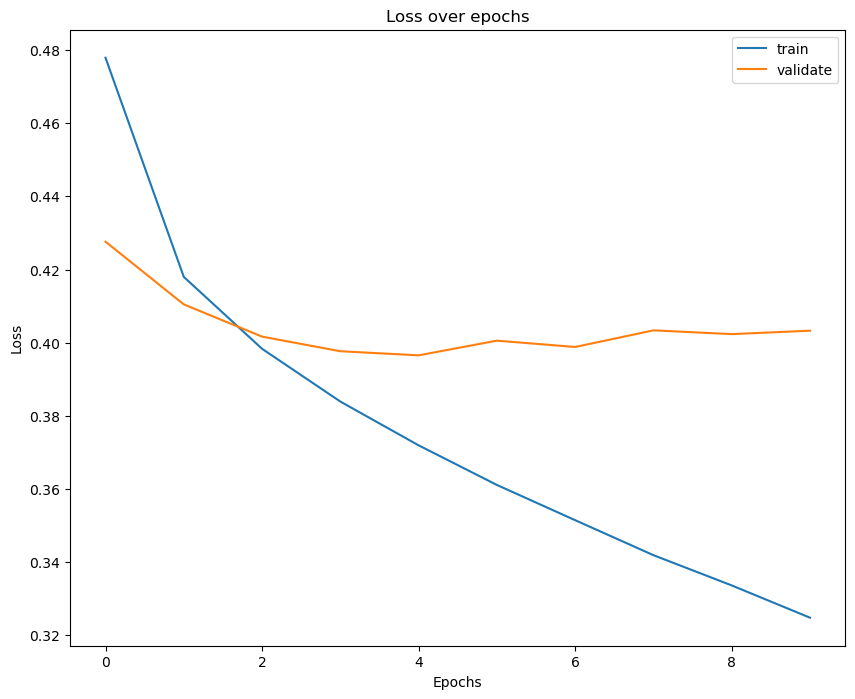

In [42]:
plot_history(cnn2_hist)

In [ ]:
y_pred_cnn1 = cnn1.predict(X_test)
y_pred_cnn2 = cnn2.predict(X_test)

y_pred_cnn1 = np.round(y_pred_cnn1)
y_pred_cnn2 = np.round(y_pred_cnn2)


y_pred_cnn1_correct = np.sum((y_pred_cnn1 == y_test) & (y_pred_cnn2 != y_test))
y_pred_cnn2_correct = np.sum((y_pred_cnn2 == y_test) & (y_pred_cnn1 != y_test))



In [ ]:
critical_value = (y_pred_cnn1_correct + y_pred_cnn2_correct)**2 / (y_pred_cnn1_correct + y_pred_cnn2_correct)
from scipy.stats import chi2
import math

1 - chi2.cdf(math.sqrt(critical_value), 1)

array([0])

In [48]:
y_pred_cnn2_correct

0